In [1]:
# Useful packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sage
import seaborn as sns
from collections import Counter, defaultdict
import itertools
import math

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.utils import check_random_state
from sklearn.metrics import mean_squared_error, brier_score_loss
from sklearn.dummy import DummyRegressor, DummyClassifier
from scipy.stats import bootstrap

rng = np.random.RandomState(0)

In [2]:
bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame
df["weather"] = df["weather"].astype(object).replace("heavy_rain", "rain").astype("category")
X_raw = df.drop(columns=["count"])  # Drop unneeded columns
categorical_cols = ['season', 'holiday', 'workingday', 'weather']
numerical_cols = [col for col in X_raw.columns if col not in categorical_cols]
df["count_norm"] = df.groupby(["year", "month"])["count"].transform(lambda x: x / x.max())

In [3]:
train_sizes = np.logspace(2, 4, 7, dtype=int)
n_train_sizes = len(train_sizes)
max_train_size = train_sizes[-1]
n_features = X_raw.shape[1]
n_folds = 5
mdi_res = np.zeros((n_train_sizes, n_folds, n_features))
umdi_res = np.zeros((n_train_sizes, n_folds, n_features))
sage_res = np.zeros((n_train_sizes, n_folds, n_features))
mse_improvement = np.zeros((n_train_sizes, n_folds))
oob_score = np.zeros((n_train_sizes, n_folds))

ts_cv = TimeSeriesSplit(n_splits=n_folds, max_train_size=max_train_size, test_size=1000, gap = 31)

for fold, (train_idx, test_idx) in enumerate(ts_cv.split(df)):
    # Extract raw fold data
    df_train = df.iloc[train_idx].copy()
    df_test = df.iloc[test_idx].copy()

    # Preprocessing
    X_train_raw = df_train.drop(columns=["count", "count_norm"])
    y_train_full = df_train["count_norm"].values

    X_test_raw = df_test.drop(columns=["count", "count_norm"])
    y_test = df_test["count_norm"].values

    preprocessor = ColumnTransformer(
        [
            ("cat", OrdinalEncoder(), categorical_cols),
            ("num", "passthrough", numerical_cols),
        ]
    )

    # Fit preprocessor on training data only
    X_train_full = preprocessor.fit_transform(X_train_raw)
    X_test = preprocessor.transform(X_test_raw)

    for train_size_idx, train_size in enumerate(train_sizes):
        train_subset_idx = rng.choice(
            np.arange(len(X_train_full)), train_size, replace=False
        )
        X_train = X_train_full[train_subset_idx]
        y_train = y_train_full[train_subset_idx]

        # Train model
        model = ExtraTreesRegressor(
            max_features=1,
            oob_score=True,
            bootstrap=True,
            n_jobs=-1,
            random_state=rng,
        )
        model.fit(X_train, y_train)

        # Collect importances
        mdi_res[train_size_idx, fold, :] = model._unnormalized_feature_importances
        umdi_res[train_size_idx, fold, :] = model.unbiased_feature_importances_

        # SAGE
        imputer = sage.MarginalImputer(model, X_test[:500])
        estimator = sage.PermutationEstimator(imputer, "mse", random_state=rng)
        sage_vals = estimator(X_test, y_test, thresh=0.5, bar=False)
        sage_res[train_size_idx, fold, :] = sage_vals.values

        # Dummy baseline
        dummy = DummyRegressor(strategy="mean")
        dummy.fit(X_train, y_train)
        mse_improvement[train_size_idx, fold] = mean_squared_error(
            y_test, dummy.predict(X_test)
        ) - mean_squared_error(y_test, model.predict(X_test))

        oob_score[train_size_idx, fold] = model.oob_score_


In [4]:
oob_score.mean(axis=1), mse_improvement.mean(axis=1)

(array([0.21761005, 0.3416033 , 0.43941488, 0.47868794, 0.53402721,
        0.61163822, 0.68844152]),
 array([0.01527104, 0.02074913, 0.02204818, 0.02715919, 0.02845183,
        0.02965927, 0.03368502]))

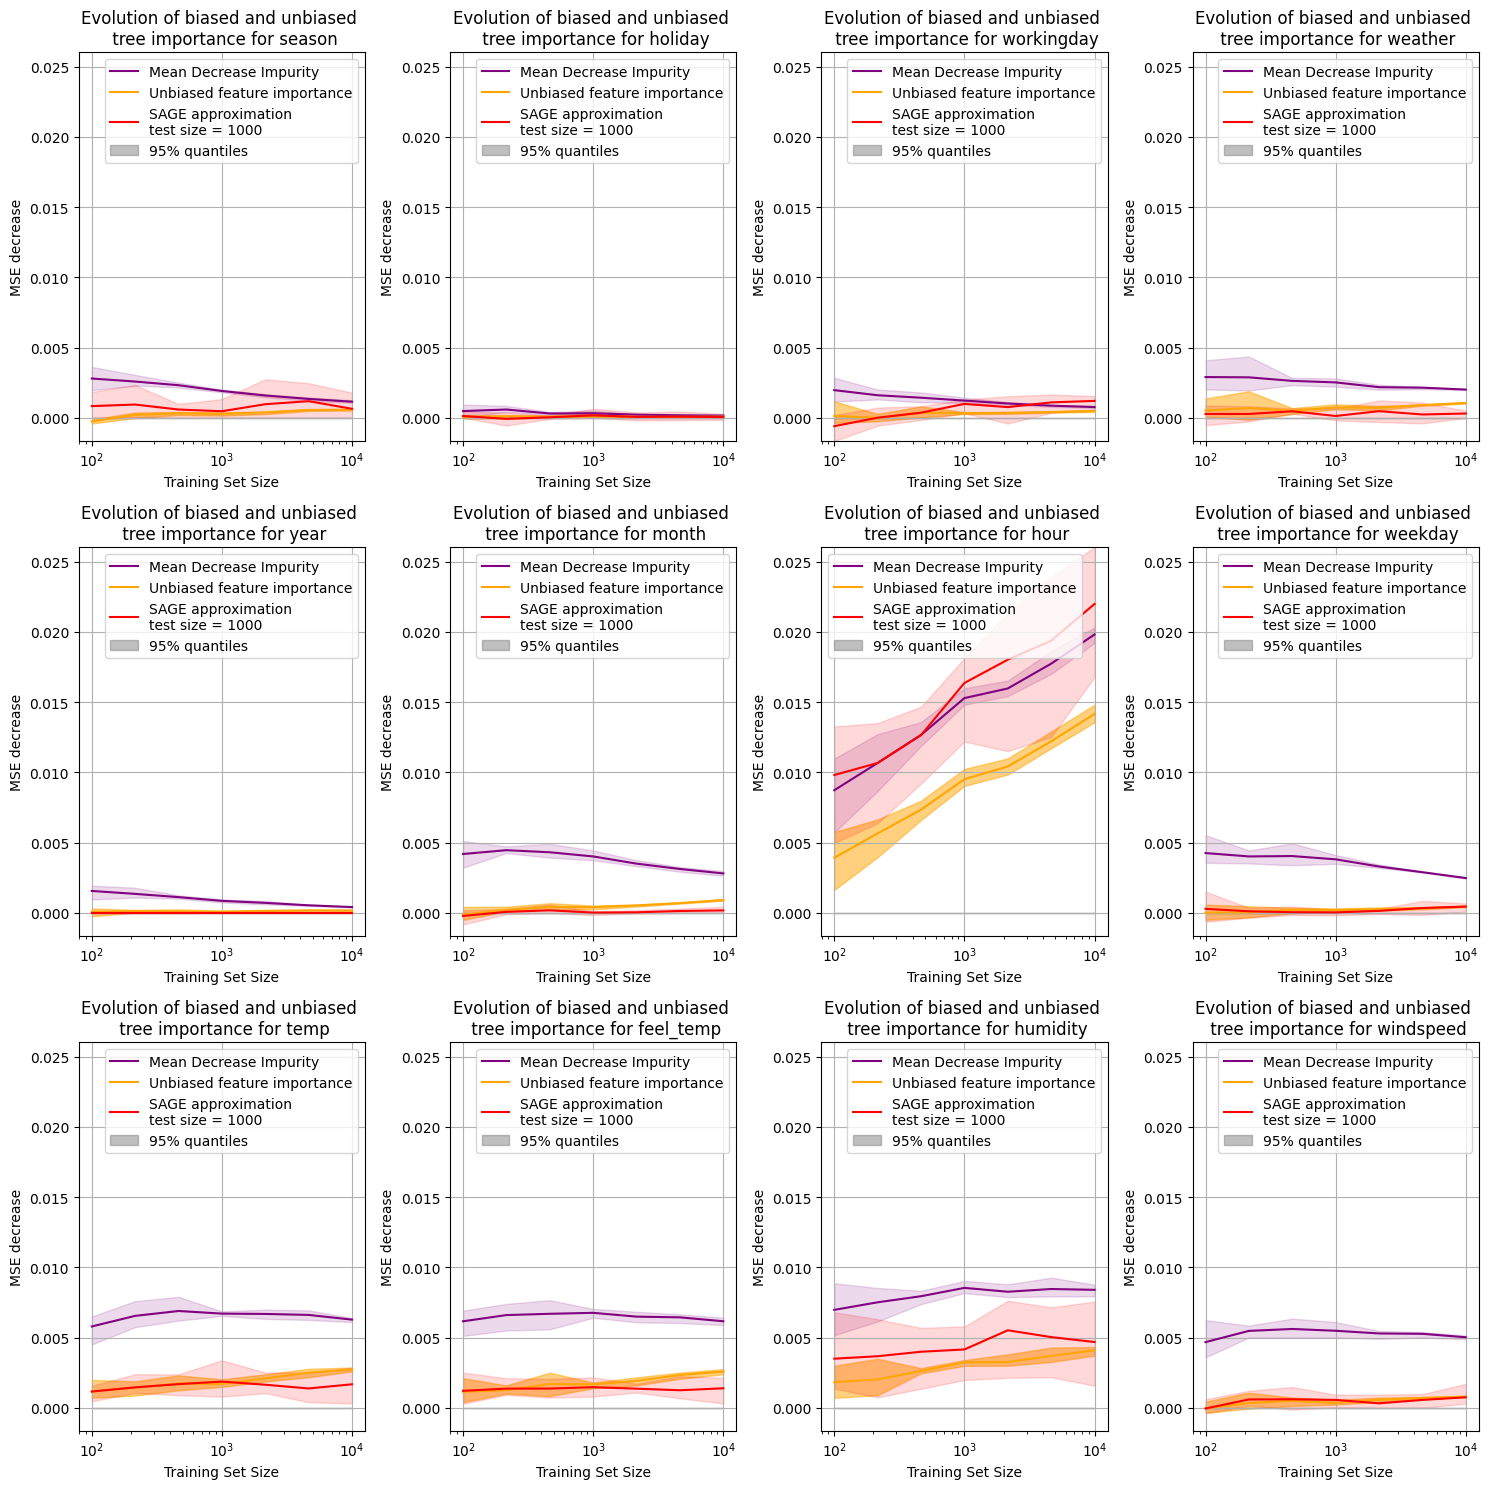

In [5]:
mean_mdi = np.zeros((n_train_sizes, n_features))
quantiles_mdi = np.zeros((n_train_sizes, n_features, 2))
mean_umdi = np.zeros((n_train_sizes, n_features))
quantiles_umdi = np.zeros((n_train_sizes, n_features, 2))
mean_sage = np.zeros((n_train_sizes, n_features))
quantiles_sage = np.zeros((n_train_sizes, n_features, 2))

for train_size_idx in range(n_train_sizes):
    mean_mdi[train_size_idx, :] = mdi_res[train_size_idx, :, :].mean(axis=0)
    quantiles_mdi[train_size_idx, :, :] = np.quantile(mdi_res[train_size_idx, :, :], q=(0.025, 0.975), axis=0).T
    mean_umdi[train_size_idx, :] = umdi_res[train_size_idx, :, :].mean(axis=0)
    quantiles_umdi[train_size_idx, :, :] = np.quantile(umdi_res[train_size_idx, :, :], q=(0.025, 0.975), axis=0).T
    mean_sage[train_size_idx, :] = sage_res[train_size_idx, :, :].mean(axis=0)
    quantiles_sage[train_size_idx, :, :] = np.quantile(sage_res[train_size_idx, :, :], q=(0.025, 0.975), axis=0).T

global_min = np.min([quantiles_mdi, quantiles_umdi, quantiles_sage])
global_max = np.max([quantiles_mdi, quantiles_umdi, quantiles_sage])
column_names = [col[5:] for col in preprocessor.get_feature_names_out()]
# Plot
fig, axs = plt.subplots(3, 4, figsize=(15, 15))
axs = axs.flatten()

for i in range(n_features):
    axs[i].set_ylim(global_min, global_max)
    axs[i].plot(train_sizes, mean_mdi[:, i], label="Mean Decrease Impurity", color='purple')
    axs[i].fill_between(
        train_sizes,
        quantiles_mdi[:, i, 0],
        quantiles_mdi[:, i, 1],
        color='purple',
        alpha=0.15,
    )
    axs[i].plot(train_sizes, mean_umdi[:, i], label="Unbiased feature importance", color='orange')
    axs[i].fill_between(
        train_sizes,
        quantiles_umdi[:, i, 0],
        quantiles_umdi[:, i, 1],
        color='orange',
        alpha=0.5,
    )
    axs[i].plot(train_sizes, mean_sage[:, i], label="SAGE approximation \ntest size = 1000", color='red')
    axs[i].fill_between(
        train_sizes,
        quantiles_sage[:, i, 0],
        quantiles_sage[:, i, 1],
        color='red',
        alpha=0.15,
    )
    axs[i].fill_between(
        train_sizes,
        0,
        0,
        color='gray',
        alpha=0.5,
        label="95% quantiles"
    )
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Training Set Size')
    axs[i].set_ylabel('MSE decrease')
    axs[i].set_title(f'Evolution of biased and unbiased \n tree importance for {column_names[i]}')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()


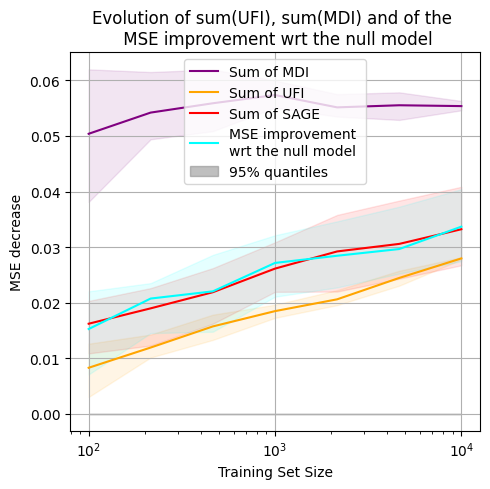

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))
axs.plot(train_sizes, mdi_res.sum(axis=-1).mean(axis=1), label="Sum of MDI", color='purple')
axs.fill_between(
    train_sizes,
    np.quantile(mdi_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 0],
    np.quantile(mdi_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 1],
    color='purple',
    alpha=0.1,
)
axs.plot(train_sizes, umdi_res.sum(axis=-1).mean(axis=1), label="Sum of UFI", color='orange')
axs.fill_between(
    train_sizes,
    np.quantile(umdi_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 0],
    np.quantile(umdi_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 1],
    color='orange',
    alpha=0.1,
)
axs.plot(train_sizes, sage_res.sum(axis=-1).mean(axis=1), label="Sum of SAGE", color='red')
axs.fill_between(
    train_sizes,
    np.quantile(sage_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 0],
    np.quantile(sage_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 1],
    color='red',
    alpha=0.1,
)
axs.plot(train_sizes, mse_improvement.mean(axis=1), label="MSE improvement \nwrt the null model", color='cyan')
axs.fill_between(
    train_sizes,
    np.quantile(mse_improvement, q=(0.025, 0.975), axis=1).T[:, 0],
    np.quantile(mse_improvement, q=(0.025, 0.975), axis=1).T[:, 1],
    color='cyan',
    alpha=0.1,
)
axs.fill_between(
    train_sizes,
    0,
    0,
    color='gray',
    alpha=0.5,
    label="95% quantiles"
)
axs.set_xscale('log')
axs.set_xlabel('Training Set Size')
axs.set_ylabel('MSE decrease')
axs.set_title('Evolution of sum(UFI), sum(MDI) and of the \n MSE improvement wrt the null model')
axs.grid(True)
axs.legend()
plt.tight_layout()
plt.show()

We don't get the expected result from Louppe where sum(ufi) approaches sage. This is probably because we are outside of the theoretical framework of binary categorical features and classification output. We will therefore encode the continuous variables in binary features.

In [7]:
def continuous_to_n_bit(array, n_bits, bin):
    if bin:
        binner = KBinsDiscretizer(n_bins=2**n_bits, strategy="quantile", quantile_method='averaged_inverted_cdf', encode="ordinal")
        int_array = binner.fit_transform(array).ravel()
    else:
        encoder = OrdinalEncoder()
        int_array = encoder.fit_transform(array).ravel()
    # Convert each integer to an 8-bit binary string
    binary_strings = [format(int(num), f'0{n_bits}b') for num in int_array]

    # Convert each binary string to a list of integers
    binary_lists = [[int(bit) for bit in binary_str] for binary_str in binary_strings]

    # Convert the list of lists into a numpy array
    binary_array = np.array(binary_lists)

    return binary_array


In [8]:
def continuous_to_1hot_bins(array, n_bins):
    binner = KBinsDiscretizer(n_bins=n_bins, strategy="quantile", quantile_method='averaged_inverted_cdf', encode="ordinal")
    int_array = binner.fit_transform(array)
    return OneHotEncoder(sparse_output=False).fit_transform(int_array)

In [9]:
binary_df = pd.DataFrame({"workingday" : OrdinalEncoder().fit_transform(df["workingday"].to_numpy()[:, np.newaxis]).ravel()})
# binary_df["weekday"] = OrdinalEncoder().fit_transform((df["weekday"].to_numpy() <= 5)[:, np.newaxis])
binary_df["holiday"] = OrdinalEncoder().fit_transform(df["holiday"].to_numpy()[:, np.newaxis])
# binary_df["clear_weather"] = OrdinalEncoder().fit_transform((df["weather"].to_numpy()=="clear")[:, np.newaxis])
scalar_feature_params = ["hour"] #, "temp", "humidity"
n_bins = 4
for feature_name in scalar_feature_params:
    feature_n_bit = continuous_to_1hot_bins(df[feature_name].to_numpy().reshape(-1, 1), n_bins=n_bins)
    for i in range(n_bins):
        binary_df[f"{feature_name}_{i}"] = feature_n_bit[:, i]

# Make the output categorical by binning
n_bins_output = 10
binner = KBinsDiscretizer(n_bins=n_bins_output, strategy="quantile", quantile_method='averaged_inverted_cdf', encode="ordinal")
binned_count = binner.fit_transform(df["count_norm"].to_numpy()[:, np.newaxis])
binary_df["count"] = OrdinalEncoder().fit_transform(binned_count)

In [10]:
train_sizes = np.logspace(2, 4, 7, dtype=int)
n_train_sizes = len(train_sizes)
max_train_size = train_sizes[-1]
n_features = len(binary_df.columns) - 1
n_folds = 5
mdi_res = np.zeros((n_train_sizes, n_folds, n_features))
umdi_res = np.zeros((n_train_sizes, n_folds, n_features))
sage_res = np.zeros((n_train_sizes, n_folds, n_features))
brier_improvement = np.zeros((n_train_sizes, n_folds))
oob_score = np.zeros((n_train_sizes, n_folds))

ts_cv = TimeSeriesSplit(n_splits=n_folds, max_train_size=max_train_size, test_size=1000, gap = 31)

for fold, (train_idx, test_idx) in enumerate(ts_cv.split(binary_df)):
    # Extract raw fold data
    df_train = binary_df.iloc[train_idx].copy()
    df_test = binary_df.iloc[test_idx].copy()

    # Preprocessing
    X_train_full = df_train.drop(columns=["count"]).values
    y_train_full = df_train["count"].values

    X_test = df_test.drop(columns=["count"]).values
    y_test = df_test["count"].values
    y_test_one_hot = OneHotEncoder(sparse_output=False, categories=[np.arange(n_bins_output)]).fit_transform(y_test[:, np.newaxis])

    for train_size_idx, train_size in enumerate(train_sizes):
        train_subset_idx = rng.choice(
            np.arange(len(X_train_full)), train_size, replace=False
        )
        X_train = X_train_full[train_subset_idx]
        y_train = y_train_full[train_subset_idx]

        # Train model
        model = ExtraTreesClassifier(
            max_features=1,
            oob_score=True,
            bootstrap=True,
            n_jobs=-1,
            random_state=rng,
        )
        model.fit(X_train, y_train)

        # Collect importances
        mdi_res[train_size_idx, fold, :] = model._unnormalized_feature_importances
        umdi_res[train_size_idx, fold, :] = model.unbiased_feature_importances_

        # SAGE
        imputer = sage.MarginalImputer(model, X_test[:500])
        estimator = sage.PermutationEstimator(imputer, "mse", random_state=rng)
        sage_vals = estimator(X_test, y_test_one_hot, thresh=0.5, bar=False)
        sage_res[train_size_idx, fold, :] = sage_vals.values

        # Dummy baseline
        dummy = DummyClassifier()
        dummy.fit(X_train, y_train)
        brier_improvement[train_size_idx, fold] = brier_score_loss(
            y_test, dummy.predict_proba(X_test)
        ) - brier_score_loss(y_test, model.predict_proba(X_test))

        oob_score[train_size_idx, fold] = model.oob_score_


In [19]:
oob_score.mean(axis=-1)

array([0.278     , 0.24372093, 0.25215517, 0.2394    , 0.25589601,
       0.25834949, 0.2637    ])

In [11]:
def powerset(iterable):
    s = list(iterable)
    return list(itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1)))

def monte_carlo_sage(data):
    """
    Monte Carlo estimate of SAGE values using sample data.
    Args:
        data: np.ndarray of shape (n_samples, d + 1)
              Each row is (x_0, ..., x_{d-1}, y)
    Returns:
        phi: np.ndarray of shape (d,), SAGE values per feature
    """
    n_samples, d_plus_1 = data.shape
    d = d_plus_1 - 1
    D = list(range(d))
    phi = np.zeros(d)
    Y_vals = np.unique(data[:, -1]).astype(int)
    n_classes = len(Y_vals)

    # Convert data into list of tuples: (x_tuple, y)
    samples = [(tuple(row[:-1]), int(row[-1])) for row in data]
    total_sample_weight = 0

    for i in range(d):
        subsets = powerset([j for j in D if j != i])
        for S in subsets:
            k = len(S)
            weight = math.factorial(k) * math.factorial(d - k - 1) / math.factorial(d - 1)

            # Group samples by X_S
            group_by_xS = defaultdict(list)
            for x, y in samples:
                xS = tuple(x[j] for j in S)
                group_by_xS[xS].append((x[i], y))

            total_contrib = 0.0

            for xS, group in group_by_xS.items():
                count_xS = len(group)
                if count_xS < 2:
                    continue

                # Estimate P(Y | X_S)
                count_y_given_xS = np.zeros(n_classes)
                for _, y in group:
                    count_y_given_xS[y] += 1
                prob_y_given_xS = count_y_given_xS / count_xS

                # Estimate P(Y | X_S, x_i)
                count_xi = {0: 0, 1: 0}
                count_y_given_xSxi = {
                    0: np.zeros(n_classes),
                    1: np.zeros(n_classes)
                }

                for x_i, y in group:
                    count_xi[x_i] += 1
                    count_y_given_xSxi[x_i][y] += 1

                if count_xi[0] == 0 or count_xi[1] == 0:
                    continue

                prob_y_given_xSxi = {
                    0: count_y_given_xSxi[0] / count_xi[0],
                    1: count_y_given_xSxi[1] / count_xi[1]
                }

                diff0 = prob_y_given_xSxi[0] - prob_y_given_xS
                diff1 = prob_y_given_xSxi[1] - prob_y_given_xS

                contrib = (
                    count_xi[0] * np.sum(diff0**2) +
                    count_xi[1] * np.sum(diff1**2)
                ) / count_xS  # Normalize by total group count

                total_contrib += contrib

            phi[i] += weight * total_contrib / d
            total_sample_weight += weight * count_xS / d

    return phi/total_sample_weight

In [12]:
# theoretical_value_montecarlo = monte_carlo_sage(binary_df.values[:1000])

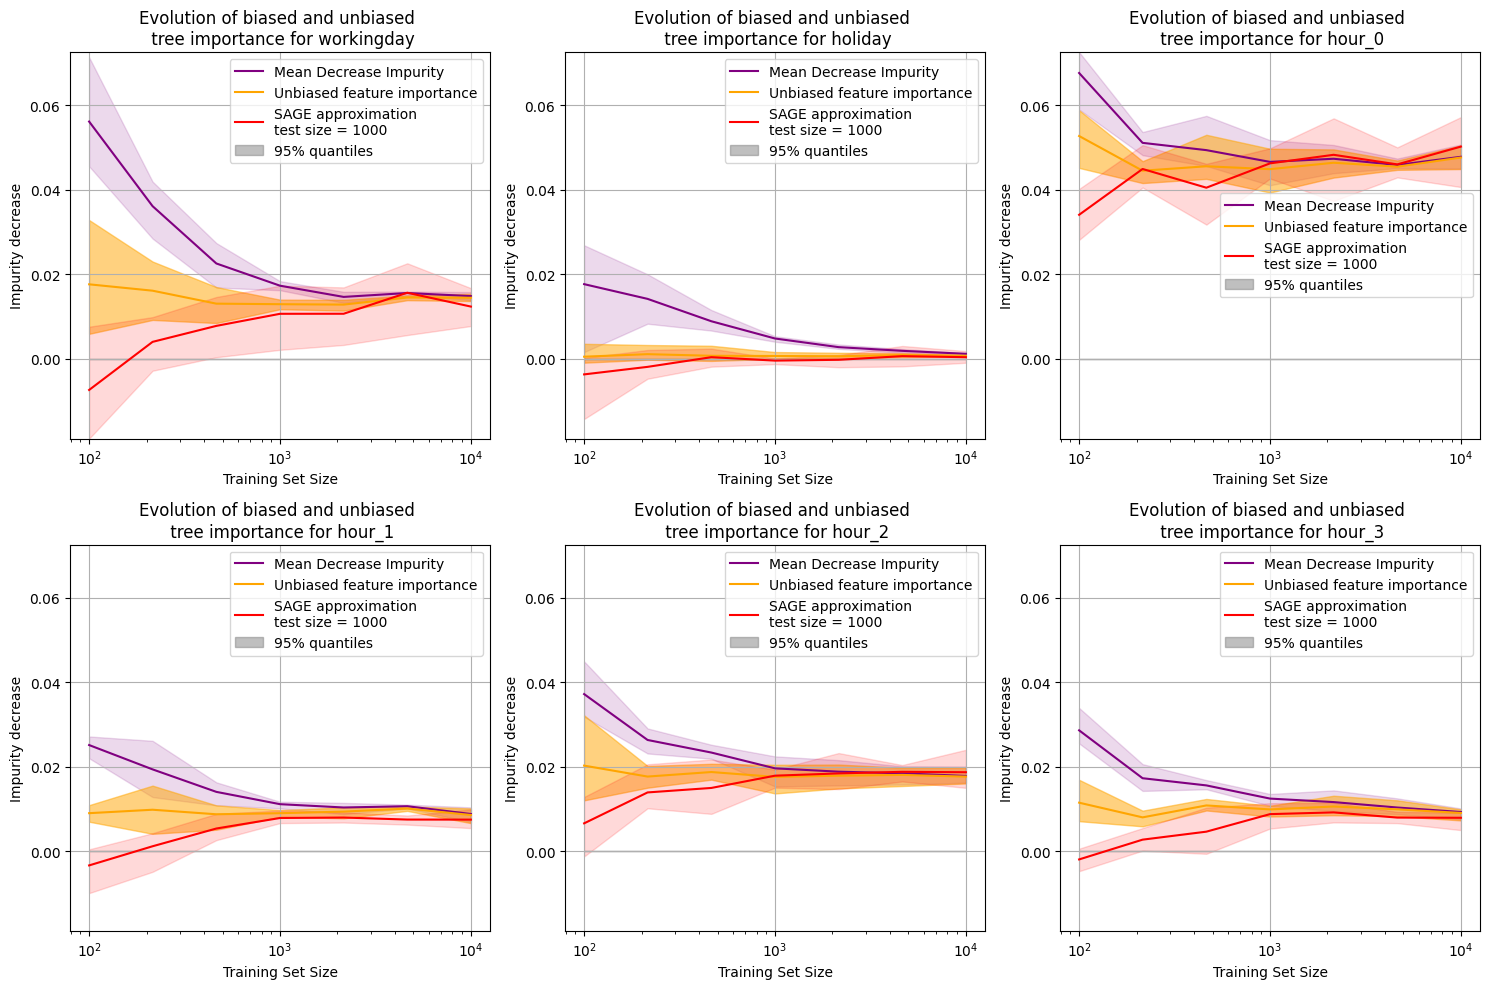

In [17]:
n_features = len(binary_df.columns) - 1
mean_mdi = np.zeros((n_train_sizes, n_features))
quantiles_mdi = np.zeros((n_train_sizes, n_features, 2))
mean_umdi = np.zeros((n_train_sizes, n_features))
quantiles_umdi = np.zeros((n_train_sizes, n_features, 2))
mean_sage = np.zeros((n_train_sizes, n_features))
quantiles_sage = np.zeros((n_train_sizes, n_features, 2))

for train_size_idx in range(n_train_sizes):
    mean_mdi[train_size_idx, :] = mdi_res[train_size_idx, :, :].mean(axis=0)
    quantiles_mdi[train_size_idx, :, :] = np.quantile(mdi_res[train_size_idx, :, :], q=(0.025, 0.975), axis=0).T
    mean_umdi[train_size_idx, :] = umdi_res[train_size_idx, :, :].mean(axis=0)
    quantiles_umdi[train_size_idx, :, :] = np.quantile(umdi_res[train_size_idx, :, :], q=(0.025, 0.975), axis=0).T
    mean_sage[train_size_idx, :] = sage_res[train_size_idx, :, :].mean(axis=0)
    quantiles_sage[train_size_idx, :, :] = np.quantile(sage_res[train_size_idx, :, :], q=(0.025, 0.975), axis=0).T

global_min = np.min([quantiles_mdi, quantiles_umdi, quantiles_sage])
global_max = np.max([quantiles_mdi, quantiles_umdi, quantiles_sage])
column_names = binary_df.drop(columns=["count"]).columns
# Plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i in range(n_features):
    axs[i].set_ylim(global_min, global_max)
    axs[i].plot(train_sizes, mean_mdi[:, i], label="Mean Decrease Impurity", color='purple')
    axs[i].fill_between(
        train_sizes,
        quantiles_mdi[:, i, 0],
        quantiles_mdi[:, i, 1],
        color='purple',
        alpha=0.15,
    )
    axs[i].plot(train_sizes, mean_umdi[:, i], label="Unbiased feature importance", color='orange')
    axs[i].fill_between(
        train_sizes,
        quantiles_umdi[:, i, 0],
        quantiles_umdi[:, i, 1],
        color='orange',
        alpha=0.5,
    )
    axs[i].plot(train_sizes, mean_sage[:, i], label="SAGE approximation \ntest size = 1000", color='red')
    axs[i].fill_between(
        train_sizes,
        quantiles_sage[:, i, 0],
        quantiles_sage[:, i, 1],
        color='red',
        alpha=0.15,
    )
    # axs[i].axhline(theoretical_value_montecarlo[i], ls="--", label="Theoretical value MC approx", color="green")
    axs[i].fill_between(
        train_sizes,
        0,
        0,
        color='gray',
        alpha=0.5,
        label="95% quantiles"
    )
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Training Set Size')
    axs[i].set_ylabel('Impurity decrease')
    axs[i].set_title(f'Evolution of biased and unbiased \n tree importance for {column_names[i]}')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

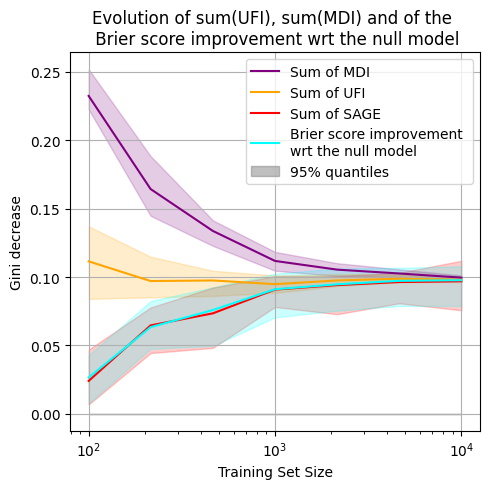

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))
axs.plot(train_sizes, mdi_res.sum(axis=-1).mean(axis=1), label="Sum of MDI", color='purple')
axs.fill_between(
    train_sizes,
    np.quantile(mdi_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 0],
    np.quantile(mdi_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 1],
    color='purple',
    alpha=0.2,
)
axs.plot(train_sizes, umdi_res.sum(axis=-1).mean(axis=1), label="Sum of UFI", color='orange')
axs.fill_between(
    train_sizes,
    np.quantile(umdi_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 0],
    np.quantile(umdi_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 1],
    color='orange',
    alpha=0.2,
)
axs.plot(train_sizes, sage_res.sum(axis=-1).mean(axis=1), label="Sum of SAGE", color='red')
axs.fill_between(
    train_sizes,
    np.quantile(sage_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 0],
    np.quantile(sage_res.sum(axis=-1), q=(0.025, 0.975), axis=1).T[:, 1],
    color='red',
    alpha=0.2,
)
axs.plot(train_sizes, brier_improvement.mean(axis=1), label="Brier score improvement \nwrt the null model", color='cyan')
axs.fill_between(
    train_sizes,
    np.quantile(brier_improvement, q=(0.025, 0.975), axis=1).T[:, 0],
    np.quantile(brier_improvement, q=(0.025, 0.975), axis=1).T[:, 1],
    color='cyan',
    alpha=0.2,
)
axs.fill_between(
    train_sizes,
    0,
    0,
    color='gray',
    alpha=0.5,
    label="95% quantiles"
)
axs.set_xscale('log')
axs.set_xlabel('Training Set Size')
axs.set_ylabel('Gini decrease')
axs.set_title('Evolution of sum(UFI), sum(MDI) and of the \n Brier score improvement wrt the null model')
axs.grid(True)
axs.legend()
plt.tight_layout()
plt.show()

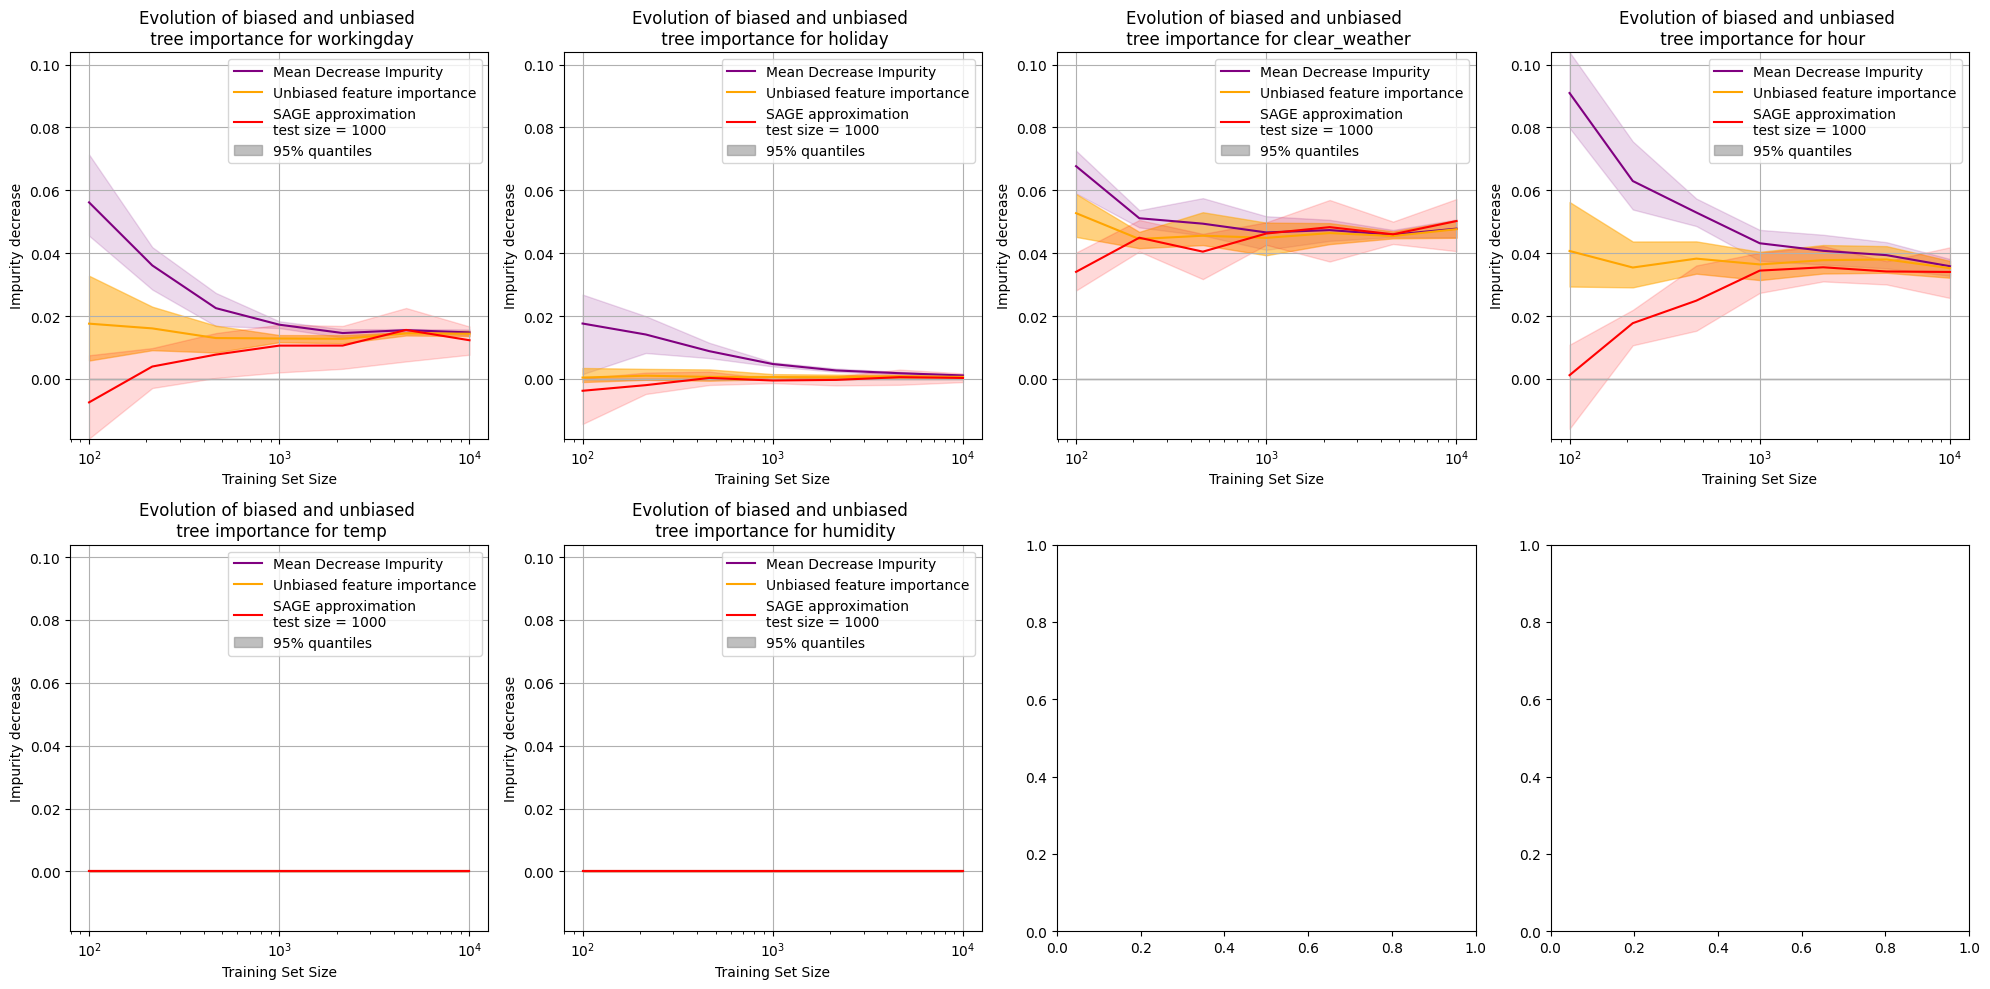

In [15]:
# Sum the features that encode different bytes of the same continuous discretized variable
column_names = [("workingday", [0,1]), ("holiday", [1, 2]), ("clear_weather", [2, 3]), ("hour", [3, 7]), ("temp", [7, 11]), ("humidity", [11, 15])]
n_features = len(column_names)
# Plot
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

mean_mdi = np.zeros((n_train_sizes, n_features))
quantiles_mdi = np.zeros((n_train_sizes, n_features, 2))
mean_umdi = np.zeros((n_train_sizes, n_features))
quantiles_umdi = np.zeros((n_train_sizes, n_features, 2))
mean_sage = np.zeros((n_train_sizes, n_features))
quantiles_sage = np.zeros((n_train_sizes, n_features, 2))

for i, (feature, slice) in enumerate(column_names):
    mean_mdi[:, i] = mdi_res[:, :, slice[0]:slice[1]].sum(axis=-1).mean(axis=1)
    quantiles_mdi[:, i, :] = np.quantile(mdi_res[:, :, slice[0]:slice[1]].sum(axis=-1), q=(0.025, 0.975), axis=1).T
    mean_umdi[:, i] = umdi_res[:, :, slice[0]:slice[1]].sum(axis=-1).mean(axis=1)
    quantiles_umdi[:, i, :] = np.quantile(umdi_res[:, :, slice[0]:slice[1]].sum(axis=-1), q=(0.025, 0.975), axis=1).T
    mean_sage[:, i] = sage_res[:, :, slice[0]:slice[1]].sum(axis=-1).mean(axis=1)
    quantiles_sage[:, i, :] = np.quantile(sage_res[:, :, slice[0]:slice[1]].sum(axis=-1), q=(0.025, 0.975), axis=1).T

global_min = np.min([quantiles_mdi, quantiles_umdi, quantiles_sage])
global_max = np.max([quantiles_mdi, quantiles_umdi, quantiles_sage])

for i, (feature, slice) in enumerate(column_names):
    axs[i].set_ylim(global_min, global_max)
    axs[i].plot(train_sizes, mean_mdi[:, i], label="Mean Decrease Impurity", color='purple')
    axs[i].fill_between(
        train_sizes,
        quantiles_mdi[:, i, 0],
        quantiles_mdi[:, i, 1],
        color='purple',
        alpha=0.15,
    )
    axs[i].plot(train_sizes, mean_umdi[:, i], label="Unbiased feature importance", color='orange')
    axs[i].fill_between(
        train_sizes,
        quantiles_umdi[:, i, 0],
        quantiles_umdi[:, i, 1],
        color='orange',
        alpha=0.5,
    )
    axs[i].plot(train_sizes, mean_sage[:, i], label="SAGE approximation \ntest size = 1000", color='red')
    axs[i].fill_between(
        train_sizes,
        quantiles_sage[:, i, 0],
        quantiles_sage[:, i, 1],
        color='red',
        alpha=0.15,
    )
    # axs[i].axhline(theoretical_value_montecarlo[i], ls="--", label="Theoretical value MC approx", color="green")
    axs[i].fill_between(
        train_sizes,
        0,
        0,
        color='gray',
        alpha=0.5,
        label="95% quantiles"
    )
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Training Set Size')
    axs[i].set_ylabel('Impurity decrease')
    axs[i].set_title(f'Evolution of biased and unbiased \n tree importance for {feature}')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()